# Project 3 Clustering 

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn import decomposition

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE

from sklearn.multiclass import OneVsRestClassifier

In [3]:
data = pd.read_csv('roe_class.csv', thousands=',', encoding = "EUC-KR")
print(data.shape)
data = data.dropna(axis=0)
print(data.shape)
data.describe()

(27396, 23)
(25669, 23)


,year,sales,roe,current_liabilities_to_assets,non_current_liabilities_to_assets,cost_of_goods_sold_to_sales,gross_profit_to_sales,selling_and_administrative_expenses_to_sales,labor_costs_to_sales,rnd_costs_to_sales,advertisement_cost_to_sales,selling_costs_to_sales,administrative_costs_to_sales,rent_to_sales,operating_income_to_sales,net_income_to_sales,sales_growth,cost_of_goods_sold_growth,sna_expenses_growth,future_roe
count,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000,25669.000000
mean,2008.717013,8.001719,0.050429,0.328832,0.124609,0.774618,0.225388,0.200423,0.069964,0.020321,0.008923,0.031740,0.053085,0.005118,0.024955,-0.035811,0.108739,0.111196,0.115754,0.041526
std,4.770249,0.710812,2.351048,0.190103,0.162176,0.226153,0.226149,0.427920,0.132452,0.242795,0.025699,0.070268,0.096115,0.020678,0.468484,2.319484,0.416893,0.468238,0.357125,2.315351
min,2000.000000,4.488551,-137.910987,0.000321,0.000000,0.000491,-12.321316,0.002601,-0.009618,-0.001408,-0.004294,-2.094313,-0.008789,-0.000628,-38.808688,-344.957143,-5.744398,-7.746389,-4.603410,-137.910987
25%,2005.000000,7.525385,0.009419,0.192197,0.037242,0.697883,0.115841,0.076665,0.027010,0.000000,0.000149,0.005457,0.016519,0.000329,0.015542,0.004580,-0.038932,-0.041853,-0.020625,0.005786
50%,2009.000000,7.925450,0.073224,0.312512,0.087534,0.814944,0.185059,0.126534,0.046246,0.001421,0.000981,0.016360,0.029858,0.001631,0.052582,0.038188,0.076310,0.078846,0.086597,0.068206
75%,2013.000000,8.379058,0.153359,0.442595,0.172882,0.884162,0.302117,0.236400,0.082619,0.014513,0.005824,0.036251,0.057979,0.004532,0.101056,0.084740,0.218045,0.224682,0.220434,0.143583
max,2016.000000,11.359252,268.047564,8.779681,16.120310,13.321316,0.999509,39.480612,10.967792,30.458631,1.516510,4.553302,4.968525,2.322141,0.954799,27.526745,7.142814,11.937225,5.736175,268.047564


In [4]:
data = data[(data['roe'] <= 2) & (data['roe'] >= -2)]
data = data[(data['future_roe'] <= 2) & (data['future_roe'] >= -2)]

# data = data[data['current_liabilities_to_assets'] <= 1]
# data = data[data['non_current_liabilities_to_assets'] <= 1]

data = data[(data['rnd_costs_to_sales'] <= 2) & (data['rnd_costs_to_sales'] > 0)]
data = data[(data['advertisement_cost_to_sales'] <= 2) & (data['advertisement_cost_to_sales'] > 0)]
data = data[(data['selling_costs_to_sales'] <= 2) & (data['selling_costs_to_sales'] > 0)]
data = data[(data['administrative_costs_to_sales'] <= 2) & (data['administrative_costs_to_sales'] > 0)]
data = data[(data['cost_of_goods_sold_growth'] <= 2) & (data['cost_of_goods_sold_growth'] > 0)]
data = data[(data['labor_costs_to_sales'] <= 2) & (data['labor_costs_to_sales'] > 0)]

# data = data[(data['net_income_to_sales'] <= 1) & (data['net_income_to_sales'] > -5)]


In [5]:
data.shape

(9525, 23)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

data.reset_index(inplace=True, drop=True)
#  'cost_of_goods_sold_to_sales', 'selling_and_administrative_expenses_to_sales', 'operating_income_to_sales', 'labor_costs_to_sales',
features = ['current_liabilities_to_assets','non_current_liabilities_to_assets', 'roe',
            'rnd_costs_to_sales','administrative_costs_to_sales', 'net_income_to_sales', 'sales_growth']

# Separating out the features
x = data.loc[:, features]
# Separating out the target
y = data['roe_class'].values
# Standardizing the features
x_trans = StandardScaler().fit_transform(x.values)

In [7]:
vif = pd.DataFrame()
vif["Column"] = features
vif["VIF Factor"] = [variance_inflation_factor(x_trans, i).round(2) for i in range(x_trans.shape[1])]
new_feature = list(vif[vif['VIF Factor'] < 5]['Column'])
vif

,Column,VIF Factor
0,current_liabilities_to_assets,1.11
1,non_current_liabilities_to_assets,1.02
2,roe,1.38
3,rnd_costs_to_sales,1.17
4,administrative_costs_to_sales,1.23
5,net_income_to_sales,1.48
6,sales_growth,1.07


In [8]:
x = data.loc[:, new_feature]
# Separating out the target
y = data['roe_class'].values
# Standardizing the features
x_trans = StandardScaler().fit_transform(x.values)

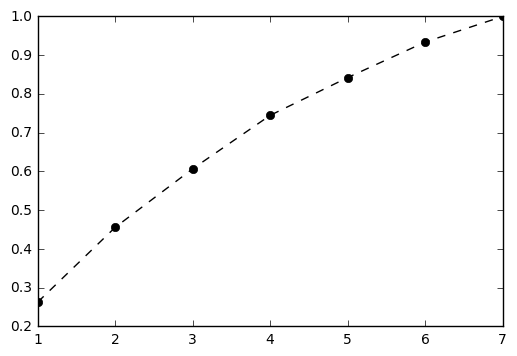

In [46]:
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(x_trans)
principalDf = pd.DataFrame(principalComponents,columns=range(7))

plt.plot(range(1,8),np.cumsum(pca.explained_variance_ratio_), 'k--o', )

# var = pca.explained_variance_
# var = var / var.sum()
# var_sum = var.cumsum()
# plt.plot(range(1,6),var_sum)

In [53]:
pd.DataFrame(pca.components_.T)

,0,1,2,3,4,5,6
0,-0.062938,-0.601095,0.417535,-0.278396,0.035474,-0.614634,-0.062055
1,0.119278,-0.273196,0.056487,0.942229,-0.003226,-0.127294,-0.062736
2,-0.512542,0.365320,0.104950,0.158555,0.270739,-0.351186,0.609145
3,0.355479,0.502014,0.173964,0.025056,-0.619816,-0.453815,-0.024614
4,0.470081,0.330209,0.132876,-0.014623,0.734367,-0.204928,-0.266130
5,-0.583344,0.212559,-0.173130,0.067134,-0.015677,-0.223577,-0.727884
6,-0.177429,0.156057,0.856485,0.064896,-0.041462,0.429836,-0.141100


In [54]:
pd.DataFrame(pca.explained_variance_)

,0
0,1.838943
1,1.351346
2,1.058136
3,0.965846
4,0.681991
5,0.642163
6,0.462310


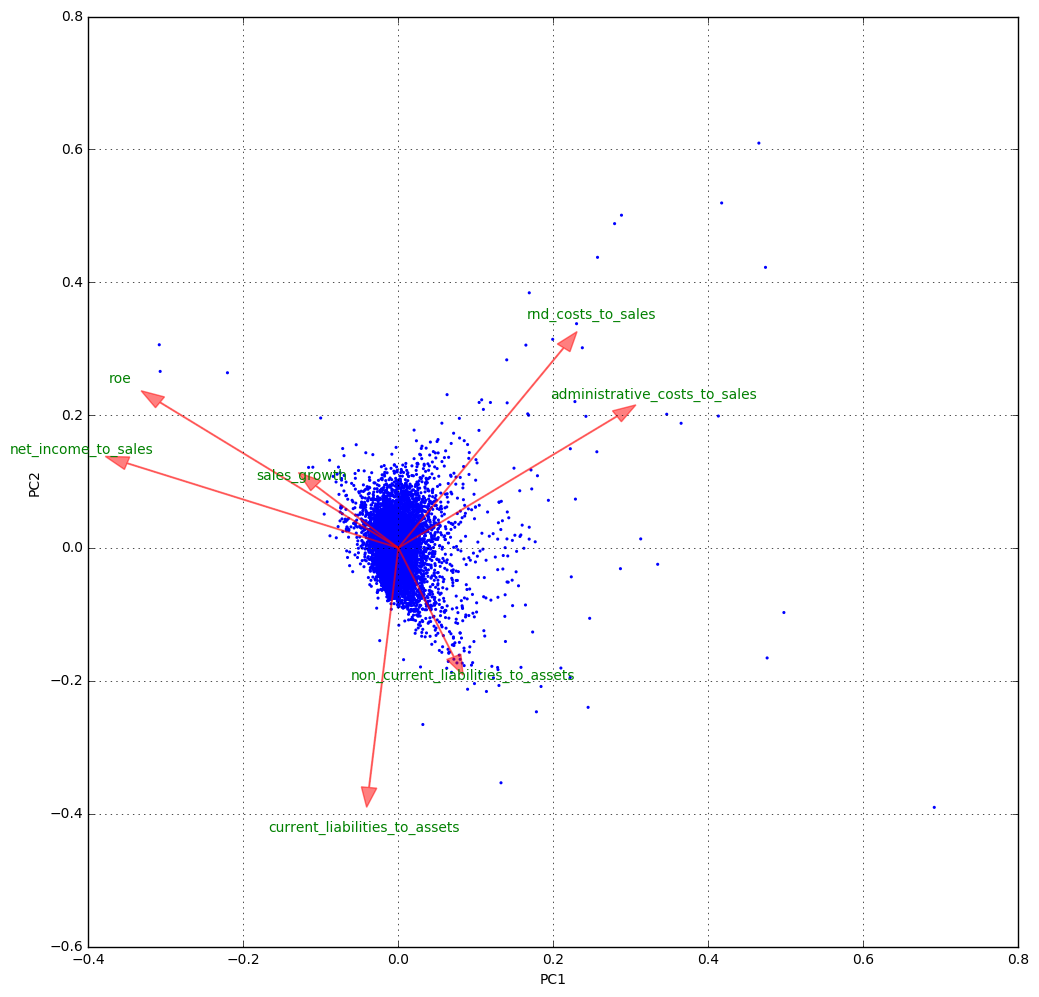

In [52]:
def myplot(score,coeff,labels=None):
    xs = score.loc[:,0]
    ys = score.loc[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,edgecolors='None', s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*0.6, coeff[i,1]*0.6,color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]*0.7, coeff[i,1]*0.7, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]*0.7,coeff[i,1]*0.7, labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(12,12))

# plt.xlim(-0.7,0.7)
# plt.ylim(-0.5,0.7)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principalDf.loc[:,[0,1]], np.transpose(pca.components_[[0,1], :]),labels=new_feature)
plt.show()

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(principalDf, 'ward')

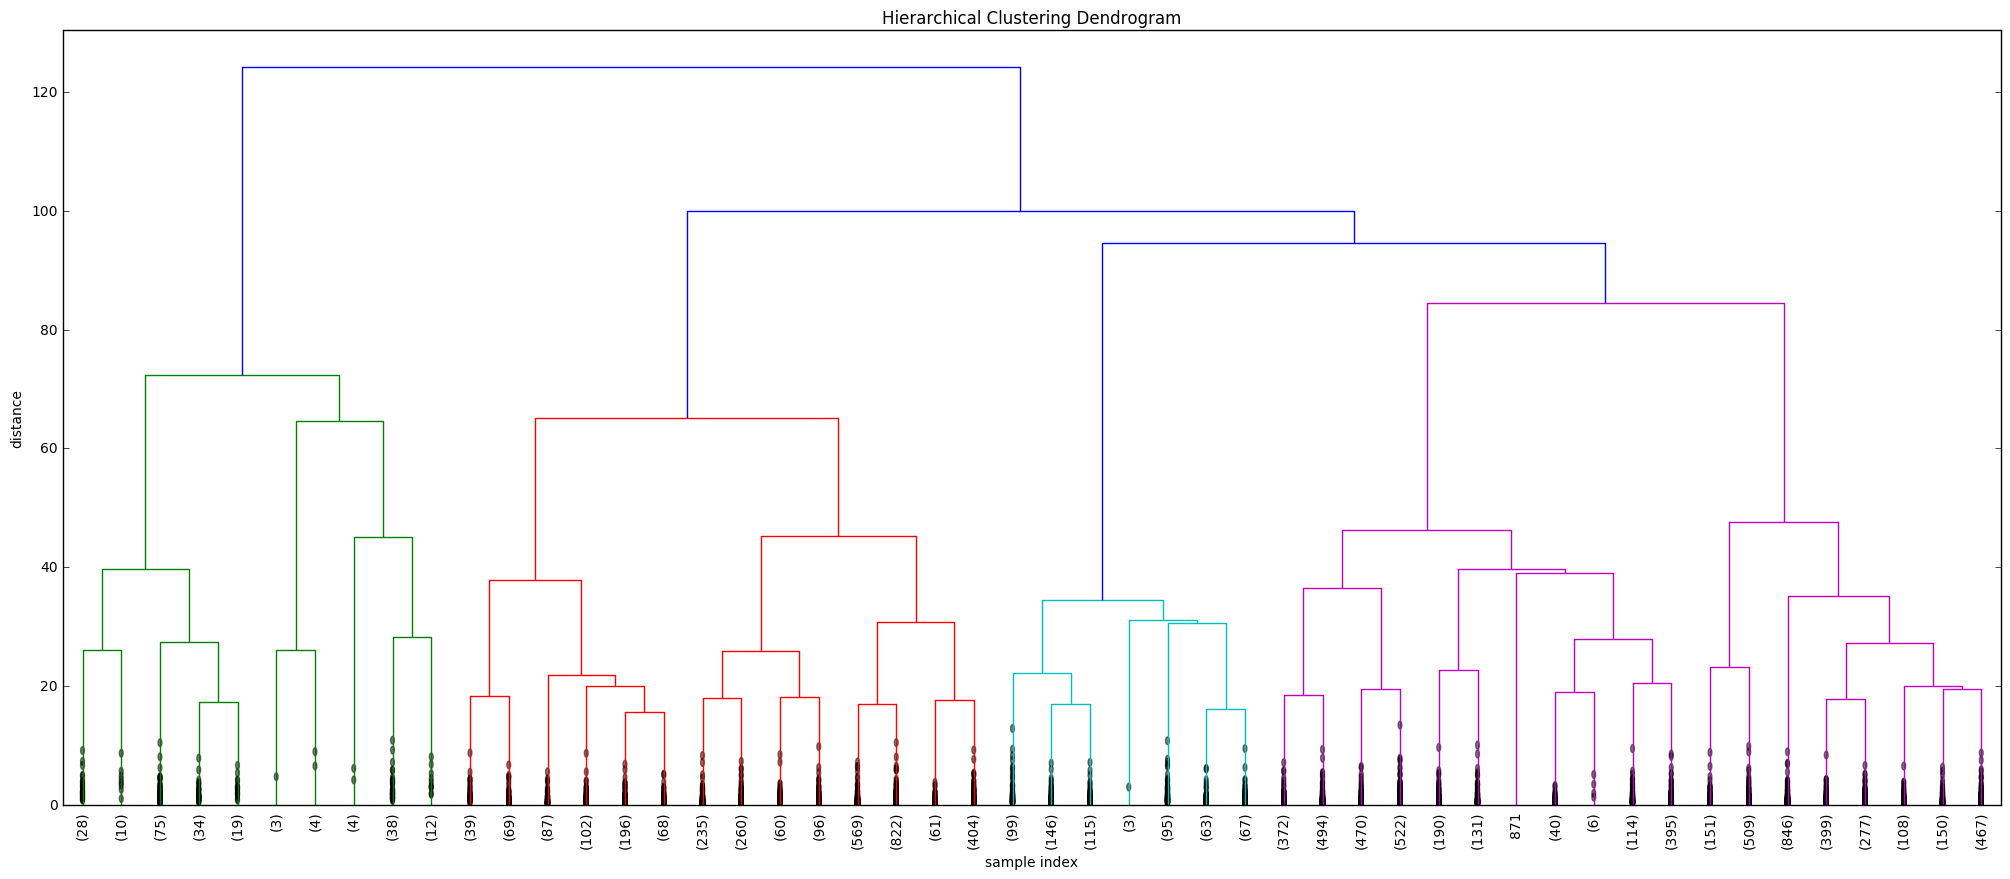

In [15]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [16]:
from scipy.cluster.hierarchy import fcluster
clusters=fcluster(Z,4, criterion='maxclust')
x['clusters'] = clusters

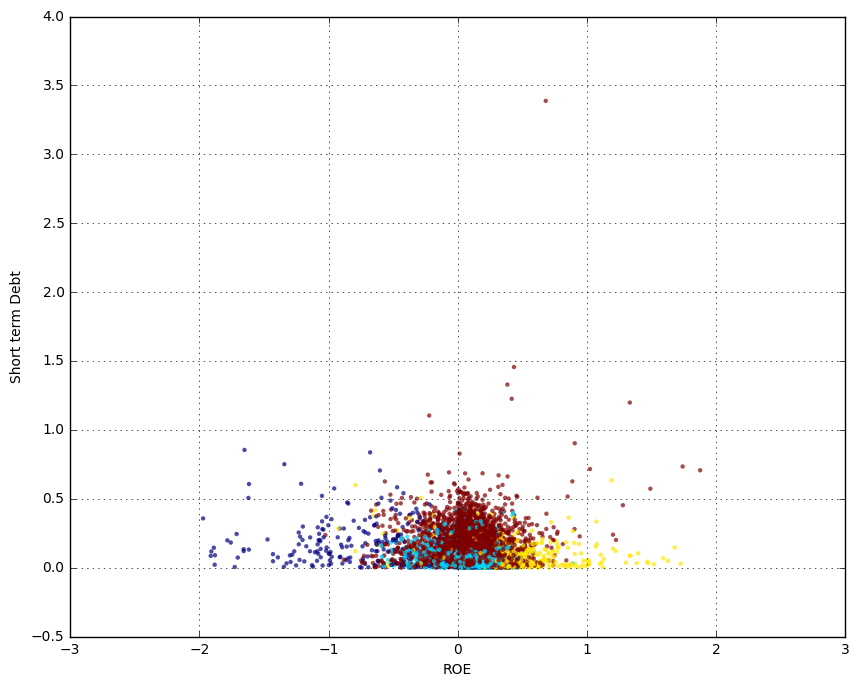

In [66]:
plt.figure(figsize=(10, 8))
plt.scatter(x['roe'],x['non_current_liabilities_to_assets'], c=x['clusters'], s=10, alpha=0.7, edgecolors='None')  # plot points with cluster dependent colors
plt.xlabel('ROE')
plt.ylabel('Short term Debt')
plt.grid(True)
plt.show()

In [39]:
x.groupby(by='clusters').mean()

,current_liabilities_to_assets,non_current_liabilities_to_assets,roe,rnd_costs_to_sales,administrative_costs_to_sales,net_income_to_sales,sales_growth,k_means
clusters,,,,,,,,
1,0.360275,0.173768,-0.719691,0.134006,0.172655,-0.906374,0.162523,2.317181
2,0.205788,0.067542,0.095420,0.031779,0.073771,0.074383,0.139803,0.216428
3,0.390182,0.097142,0.334574,0.022837,0.046884,0.130752,0.971963,0.981293
4,0.382871,0.146988,0.094233,0.012700,0.033647,0.035923,0.211450,2.178660


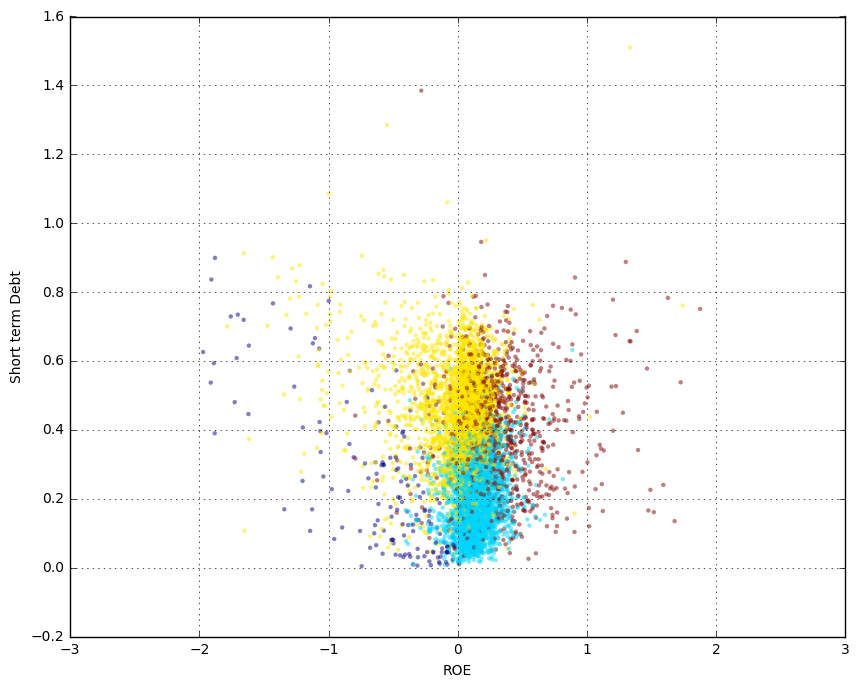

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4).fit(principalDf)
x['k_means'] = kmeans.labels_
plt.figure(figsize=(10, 8))
plt.scatter(data['roe'],data['current_liabilities_to_assets'], c=data['k_means'], s=10, alpha=0.5, edgecolors='None')  # plot points with cluster dependent colors
plt.xlabel('ROE')
plt.ylabel('Short term Debt')
plt.grid(True)

plt.show()


In [38]:
x.groupby(by='k_means').mean()

,current_liabilities_to_assets,non_current_liabilities_to_assets,roe,rnd_costs_to_sales,administrative_costs_to_sales,net_income_to_sales,sales_growth,clusters
k_means,,,,,,,,
0,0.207403,0.075667,0.125432,0.029639,0.061791,0.090930,0.153619,2.594702
1,0.385102,0.117868,0.297521,0.022792,0.044379,0.102183,0.791294,3.440285
2,0.249945,0.155012,-0.584763,0.186478,0.244275,-1.182330,0.198597,1.109677
3,0.426277,0.159467,0.025652,0.009222,0.034616,0.000800,0.164230,3.844856
